In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics

from ast import literal_eval

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 15000
stocks = ['9064', '9061', '9265']
should_save_fig = False # TODO: change plot names if changing that value

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d,  d_test = lob.load_prepared_data(
        s, data_dir='../queue_imbalance/data/prepared', cv=False, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d['prev_queue_imbalance'] = [None] + d['queue_imbalance'].iloc[0:len(d)-1].values.tolist()
    d.dropna(inplace=True)
    d_test['prev_queue_imbalance'] = [None] + d_test['queue_imbalance'].iloc[0:len(d_test)-1].values.tolist()
    d_test.dropna(inplace=True)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
d_stocks['9061'].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,prev_queue_imbalance
2013-09-13 10:37:00,2013-09-13 10:37:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.3, 9528.0), (699.4, 17958.0), (699.5, 28...",699.1,699.3,699.20,9528.0,3722.0,1.0,-0.438189,0.399368
2013-09-13 10:39:00,2013-09-13 10:39:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.5, 3954.0), (699.6, 10269.0), (699.7, 16...",699.4,699.5,699.45,3954.0,4580.0,0.0,0.073354,-0.438189
2013-09-13 10:40:00,2013-09-13 10:40:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.5, 3724.0), (699.6, 11982.0), (699.7, 16...",699.3,699.5,699.40,3724.0,8567.0,1.0,0.394028,0.073354
2013-09-13 10:41:00,2013-09-13 10:41:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.6, 458.0), (699.7, 13014.0), (699.8, 334...",699.5,699.6,699.55,458.0,3667.0,0.0,0.777939,0.394028
2013-09-13 10:42:00,2013-09-13 10:42:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.4, 8370.0), (699.5, 19897.0), (699.6, 16...",699.1,699.4,699.25,8370.0,6055.0,1.0,-0.160485,0.777939


## SVM with queue imbalance

In [5]:
df_res = {}
for s in stocks:
    df_res_temp = pd.read_csv('res_{}_prev_queue_imbalance.csv'.format(s))
    df_res_temp = df_res_temp[df_res_temp['features'] == 'queue_imbalance']
    df_res_temp = df_res_temp[df_res_temp['method'] == 'svm_linear']
    df_res_temp['stock'] = [s for i in range(len(df_res_temp))]
    df_res[s] = df_res_temp
    columns_to_mean = ['f1', 'kappa', 'matthews', 
       'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']
    for c in columns_to_mean:
        cc = []
        for i, row in df_res[s].iterrows():
            cc.append(np.array(literal_eval(row[c])).mean())
        df_res[s][c] = cc

In [6]:
df_res['9265'].sort_values(by='matthews', ascending=False).head()

,Unnamed: 0,f1,features,kappa,matthews,method,precision,recall,roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc,c,coef0,gamma,stock
367,367,0.557964,queue_imbalance,0.102687,0.103118,svm_linear,0.560522,0.557665,0.551296,0.555332,0.103867,0.103981,0.549842,0.561399,0.551902,0.1,NaN,NaN,9265
375,375,0.557376,queue_imbalance,0.102319,0.102754,svm_linear,0.560377,0.556699,0.551114,0.554843,0.103263,0.103378,0.549576,0.560693,0.551599,1000.0,NaN,NaN,9265
369,369,0.557377,queue_imbalance,0.102304,0.102741,svm_linear,0.560386,0.556699,0.551106,0.555031,0.103443,0.103557,0.549653,0.560987,0.551690,1.0,NaN,NaN,9265
371,371,0.557377,queue_imbalance,0.102304,0.102741,svm_linear,0.560386,0.556699,0.551106,0.554843,0.103314,0.103428,0.549609,0.560657,0.551625,10.0,NaN,NaN,9265
373,373,0.557323,queue_imbalance,0.102113,0.102549,svm_linear,0.560275,0.556699,0.551010,0.554843,0.103314,0.103428,0.549609,0.560657,0.551625,100.0,NaN,NaN,9265


In [7]:
df_best_svm = pd.DataFrame()
for s in stocks:
    idx_max = df_res[s]['matthews'].idxmax()
    df_best_svm = df_best_svm.append(df_res[s].loc[idx_max])
df_best_svm

,Unnamed: 0,c,coef0,f1,features,gamma,kappa,matthews,method,precision,recall,roc_auc,stock,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
367,367.0,0.1,NaN,0.553037,queue_imbalance,NaN,0.085347,0.085650,svm_linear,0.547900,0.559761,0.542736,9064,0.556975,0.082493,0.082544,0.548817,0.565444,0.541222
369,369.0,1.0,NaN,0.477803,queue_imbalance,NaN,0.079938,0.080413,svm_linear,0.486067,0.472556,0.540002,9061,0.470377,0.080558,0.080607,0.475813,0.465230,0.540233
367,367.0,0.1,NaN,0.557964,queue_imbalance,NaN,0.102687,0.103118,svm_linear,0.560522,0.557665,0.551296,9265,0.555332,0.103867,0.103981,0.549842,0.561399,0.551902


In [8]:
df_res['9064']

,Unnamed: 0,f1,features,kappa,matthews,method,precision,recall,roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc,c,coef0,gamma,stock
363,363,0.672139,queue_imbalance,0.000692,0.002195,svm_linear,0.506960,0.997647,0.500337,0.674899,0.000591,0.002284,0.509727,0.998444,0.500292,0.001,NaN,NaN,9064
365,365,0.566245,queue_imbalance,0.074654,0.074972,svm_linear,0.542692,0.609033,0.537399,0.571494,0.073668,0.073746,0.544410,0.616801,0.536807,0.010,NaN,NaN,9064
367,367,0.553037,queue_imbalance,0.085347,0.085650,svm_linear,0.547900,0.559761,0.542736,0.556975,0.082493,0.082544,0.548817,0.565444,0.541222,0.100,NaN,NaN,9064
369,369,0.552349,queue_imbalance,0.084656,0.084964,svm_linear,0.547579,0.558734,0.542391,0.556423,0.081973,0.082017,0.548629,0.564491,0.540963,1.000,NaN,NaN,9064
371,371,0.552349,queue_imbalance,0.084656,0.084964,svm_linear,0.547579,0.558734,0.542391,0.556403,0.081963,0.082007,0.548626,0.564456,0.540958,10.000,NaN,NaN,9064
373,373,0.552349,queue_imbalance,0.084656,0.084964,svm_linear,0.547579,0.558734,0.542391,0.556393,0.081924,0.081968,0.548605,0.564456,0.540939,100.000,NaN,NaN,9064
375,375,0.552266,queue_imbalance,0.084657,0.084966,svm_linear,0.547595,0.558557,0.542392,0.556273,0.082013,0.082056,0.548674,0.564134,0.540984,1000.000,NaN,NaN,9064


In [9]:
print(df_best_svm[['stock', 'method', 'c', 'gamma', 'coef0']].to_latex())

\begin{tabular}{lllrrr}
\toprule
{} & stock &      method &    c &  gamma &  coef0 \\
\midrule
367 &  9064 &  svm\_linear &  0.1 &    NaN &    NaN \\
369 &  9061 &  svm\_linear &  1.0 &    NaN &    NaN \\
367 &  9265 &  svm\_linear &  0.1 &    NaN &    NaN \\
\bottomrule
\end{tabular}



In [10]:
def fit_best_svm_classifier(df_best_svm, df, stock=None):
    gamma = df_best_svm[df_best_svm['stock'] == stock]['gamma'].values[0]
    coef0 = df_best_svm[df_best_svm['stock'] == stock]['coef0'].values[0]
    c = df_best_svm[df_best_svm['stock'] == stock]['c'].values[0]
    kernel = df_best_svm[df_best_svm['stock'] == stock]['method'].values[0].split('_')[1]

    X = df['queue_imbalance'].values.reshape(-1, 1)
    y = df['mid_price_indicator']
    
    clf = SVC(gamma=gamma, C=c, coef0=coef0, kernel=kernel, random_state=12313)
    clf.fit(X, y)
    return clf
    

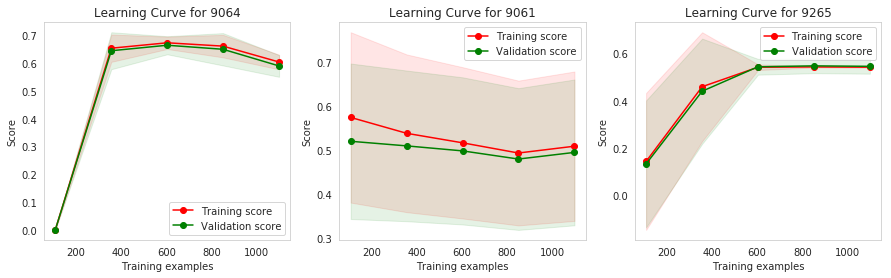

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

f, ax = plt.subplots(1, 3, figsize=(15,4))
i = 0
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    lob.plot_learning_curve(
        log_clf, d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1),
        d_stocks[stock]['mid_price_indicator'], 
        cv=TimeSeriesSplit(n_splits=10, max_train_size=9000), ax=ax[i], scoring='f1')
    ax[i].set_title('Learning Curve for {}'.format(stock))
    i += 1
if should_save_fig:
    print('Saving')
    plt.savefig('svm_learning_curves.png')

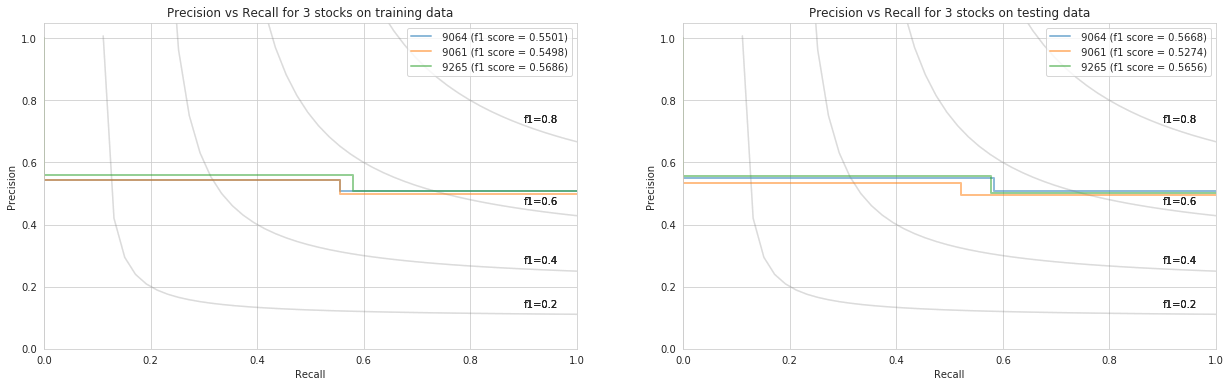

In [12]:
f, (ax1, ax3) = plt.subplots(1, 2, figsize=(21,6))
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    pred_train = log_clf.predict(d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    pred_test = log_clf.predict(d_test_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    d_stocks[stock]['pred_log'] = pred_train
    d_test_stocks[stock]['pred_log'] = pred_test
    lob.plot_f1(d_stocks[stock], log_clf, stock=stock, label='', ax=ax1,
                 title='Precision vs Recall for 3 stocks on training data')
    lob.plot_f1(d_test_stocks[stock], log_clf, stock=stock, label='', ax=ax3,
                 title='Precision vs Recall for 3 stocks on testing data')
    if should_save_fig:
        print('Saving')
        plt.savefig('svm_results.png')

In [13]:
def get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score, 
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    dfs = {'train': d_stocks[stock], 'test': d_test_stocks[stock], }
    res_train = model.validate_model(fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock), 
                                     d_stocks[stock][['queue_imbalance']], d_stocks[stock]['mid_price_indicator'])
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    res = {**res, **res_train}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

In [14]:
df_scores[['train_precision', 'precision', 'test_precision', 'train_recall', 'recall', 'test_recall']]

,train_precision,precision,test_precision,train_recall,recall,test_recall
9064,"[0.5210688591983555, 0.5374149659863946, 0.542...","[0.49478079331941544, 0.5700934579439252, 0.52...",0.550680,"[0.8973451327433628, 0.5771689497716895, 0.593...","[0.8943396226415095, 0.5313588850174216, 0.501...",0.583879
9061,"[0.5572649572649573, 0.5257936507936508, 0.519...","[0.4803921568627451, 0.5043103448275862, 0.570...",0.533333,"[0.5895117540687161, 0.5125725338491296, 0.505...","[0.6112266112266113, 0.4508670520231214, 0.482...",0.521505
9265,"[0.5509803921568628, 0.5493885230479775, 0.546...","[0.556910569105691, 0.5381818181818182, 0.5293...",0.554773,"[0.5311909262759924, 0.541241890639481, 0.5332...","[0.49818181818181817, 0.5606060606060606, 0.55...",0.576949


In [15]:
df_scores[['train_f1', 'f1', 'test_f1_score', 'train_roc_auc', 'roc_auc', 'test_roc_auc']]

,train_f1,f1,test_f1_score,train_roc_auc,roc_auc,test_roc_auc
9064,"[0.659297789336801, 0.5565830030823427, 0.5668...","[0.6370967741935484, 0.5500450856627591, 0.515...",0.566794,"[0.5048630425621575, 0.5378932306462134, 0.536...","[0.5150269541778976, 0.5428112254544473, 0.527...",0.545164
9061,"[0.5729349736379614, 0.5190989226248776, 0.512...","[0.5379688929551693, 0.4760935910478128, 0.522...",0.527353,"[0.5536013146507455, 0.5477347835039714, 0.541...","[0.5445295617709411, 0.5240324752234696, 0.564...",0.536067
9265,"[0.5409047160731473, 0.5452847805788983, 0.540...","[0.5259117082533589, 0.549165120593692, 0.5403...",0.565643,"[0.5614956413911156, 0.5530914267003036, 0.553...","[0.5472390572390573, 0.5543243826161975, 0.535...",0.556498


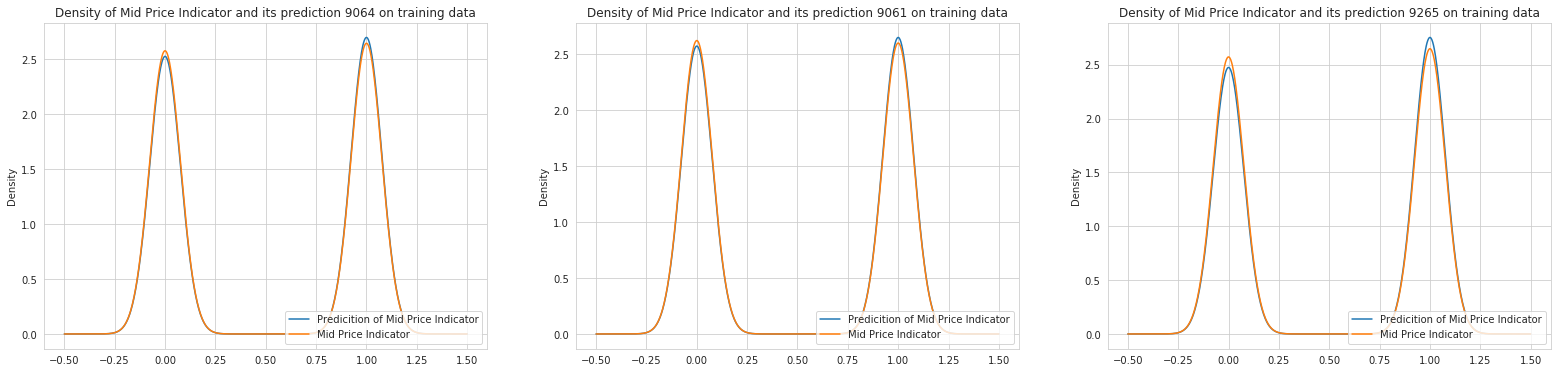

In [16]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    s = stocks[i]
    d_stocks[s]['Predicition of Mid Price Indicator'] = d_stocks[s]['pred_log']
    d_stocks[s]['Mid Price Indicator'] = d_stocks[s]['mid_price_indicator']
    d_stocks[s][['Predicition of Mid Price Indicator', 'Mid Price Indicator']].plot(
        kind='kde', ax=ax[i])
    ax[i].set_title('Density of Mid Price Indicator and its prediction {} on training data'.format(s))
    ax[i].legend(loc='lower right')
if should_save_fig:
    print('Saving')
    plt.savefig('density_of_mid_price_and_prediction_training_data_svm.png')

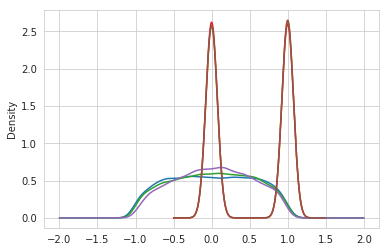

In [17]:
for s in stocks:
    d_stocks[s]['queue_imbalance'].plot(kind='kde')
    d_stocks[s]['mid_price_indicator'].plot(kind='kde')

In [18]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores


,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_f1_score,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
9064,0.555308,0.075473,0.077408,0.544952,0.578985,0.537803,9064,0.566794,0.090427,0.090598,0.550680,0.583879,0.545164,0.569723,0.550061,0.067070,0.067816,0.541569,0.609745,0.533486
9061,0.536842,0.093217,0.094234,0.544387,0.535578,0.546819,9061,0.527353,0.072146,0.072164,0.533333,0.521505,0.536067,0.532723,0.549826,0.089857,0.089895,0.535230,0.530432,0.544898
9265,0.562654,0.105840,0.106577,0.560950,0.567820,0.552956,9265,0.565643,0.113001,0.113092,0.554773,0.576949,0.556498,0.555962,0.568596,0.107507,0.107601,0.551404,0.560984,0.553727


In [24]:
print('linear kernel')
df_scores[['matthews', 'test_matthews']]

linear kernel


,matthews,test_matthews
9064,0.077408,0.090598
9061,0.094234,0.072164
9265,0.106577,0.113092


In [25]:
print('linear kernel')
df_scores[['roc_auc', 'test_roc_auc']]

linear kernel


,roc_auc,test_roc_auc
9064,0.537803,0.545164
9061,0.546819,0.536067
9265,0.552956,0.556498


In [20]:
print(df_scores[['matthews', 'test_matthews', 'roc_auc', 'test_roc_auc']].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  matthews &  test\_matthews &   roc\_auc &  test\_roc\_auc \\
\midrule
9064 &  0.077408 &       0.090598 &  0.537803 &      0.545164 \\
9061 &  0.094234 &       0.072164 &  0.546819 &      0.536067 \\
9265 &  0.106577 &       0.113092 &  0.552956 &      0.556498 \\
\bottomrule
\end{tabular}



In [21]:
print(df_scores[['f1', 'test_f1_score', 'precision', 'test_precision', 'recall', 'test_recall']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &        f1 &  test\_f1\_score &  precision &  test\_precision &    recall &  test\_recall \\
\midrule
9064 &  0.555308 &       0.566794 &   0.544952 &        0.550680 &  0.578985 &     0.583879 \\
9061 &  0.536842 &       0.527353 &   0.544387 &        0.533333 &  0.535578 &     0.521505 \\
9265 &  0.562654 &       0.565643 &   0.560950 &        0.554773 &  0.567820 &     0.576949 \\
\bottomrule
\end{tabular}



In [22]:
df_best_svm

,Unnamed: 0,c,coef0,f1,features,gamma,kappa,matthews,method,precision,recall,roc_auc,stock,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
367,367.0,0.1,NaN,0.553037,queue_imbalance,NaN,0.085347,0.085650,svm_linear,0.547900,0.559761,0.542736,9064,0.556975,0.082493,0.082544,0.548817,0.565444,0.541222
369,369.0,1.0,NaN,0.477803,queue_imbalance,NaN,0.079938,0.080413,svm_linear,0.486067,0.472556,0.540002,9061,0.470377,0.080558,0.080607,0.475813,0.465230,0.540233
367,367.0,0.1,NaN,0.557964,queue_imbalance,NaN,0.102687,0.103118,svm_linear,0.560522,0.557665,0.551296,9265,0.555332,0.103867,0.103981,0.549842,0.561399,0.551902


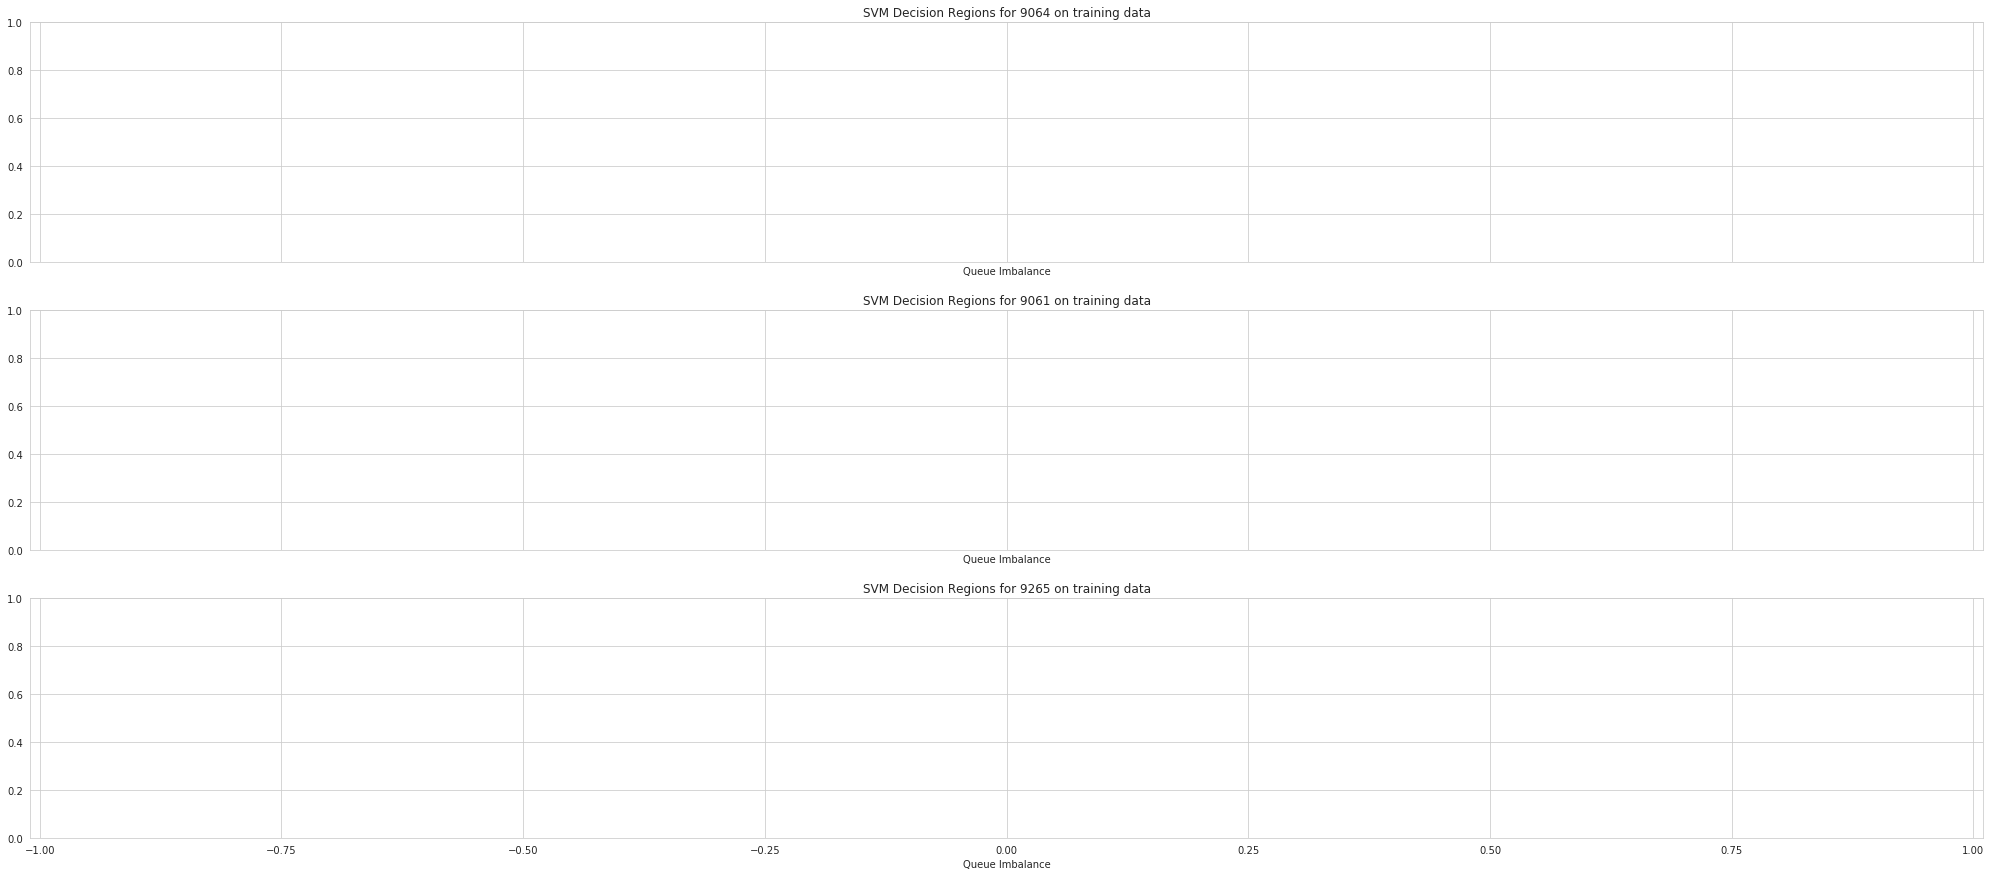

In [23]:
f, ax = plt.subplots(3, 1, figsize=(35, 15), sharex=True)
i = 0

for i in range(len(stocks)):
    s = stocks[i]
    df = d_stocks[s]
    X = d_stocks[s][['queue_imbalance']].values
    y = d_stocks[s]['mid_price_indicator'].values.astype(np.integer)

    clf = fit_best_svm_classifier(df_best_svm, d_stocks[s], stock=s)
    # plot_decision_regions(X[0:1500], y[0:1500], clf=clf,ax=ax[i], colors=','.join(['orange', 'blue']))
    ax[i].set_xlabel('Queue Imbalance')
    ax[i].set_title('SVM Decision Regions for {} on training data'.format(s))
    ax[i].set_xlim(-1.01, 1.01)

if should_save_fig:
    print('Saving')
    plt.savefig('svm_decision_region.png')

## Compare Queue Imbalance vs Prev Queue Imblanace